# Bayesian Black-box model-predictive control

In this notebook, I test the NARX-EFE agent on a single pendulum setting.

## System: single pendulum

Consider a single pendulum with angle $\theta$ evolving according to:

$$ \ddot{\theta} = - \frac{\mathcal{g}}{l} sin(\theta) \, .$$

where $l$ is length and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using Optim
using RxInfer
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=10Plots.pt)
include("../util.jl")

angle2pos (generic function with 1 method)

In [2]:
mutable struct Pendulum

    state       ::Vector{Float64}
    sensor      ::Float64
    
    mass        ::Float64
    length      ::Float64
    mnoise_sd   ::Float64 # measurement noise standard deviation

    function Pendulum(init_state, mass, length, mnoise_sd)
        
        init_sensor = init_state[1] + mnoise_sd*randn()
        
        return new(init_state, init_sensor, mass, length, mnoise_sd)
    end
end

In [3]:
function params(sys::Pendulum)
    return (sys.mass, sys.length)
end

params (generic function with 1 method)

In [4]:
function dzdt(state::Vector, u::Float64, params::Tuple)
    
    mass, length = params
    
    return [state[2]; -9.81/length * sin(state[1]) + 1/mass * u]    
end

dzdt (generic function with 1 method)

In [5]:
function RK4(sys::Pendulum, u::Float64; Δt::Float64=1.0)
    
    K1 = dzdt(sys.state          , u, params(sys))
    K2 = dzdt(sys.state + K1*Δt/2, u, params(sys))
    K3 = dzdt(sys.state + K2*Δt/2, u, params(sys))
    K4 = dzdt(sys.state + K3*Δt  , u, params(sys))
    
    return Δt/6 * (K1 + 2K2 + 2K3 + K4)
end

RK4 (generic function with 1 method)

In [6]:
function update!(sys::Pendulum, u::Float64; Δt::Float64 = 1.0)
    
    sys.state  = sys.state + RK4(sys, u, Δt=Δt)
    
    sys.sensor = sys.state[1] + sys.mnoise_sd * randn()
    
end

update! (generic function with 1 method)

In [7]:
# Define system
pendulum_mass = 2.0
pendulum_length = 0.8
mnoise_sd = 0.1

init_state = [π/2, 0.0]

pendulum = Pendulum(init_state, pendulum_mass, pendulum_length, mnoise_sd)

Pendulum([1.5707963267948966, 0.0], 1.547635100599432, 2.0, 0.8, 0.1)

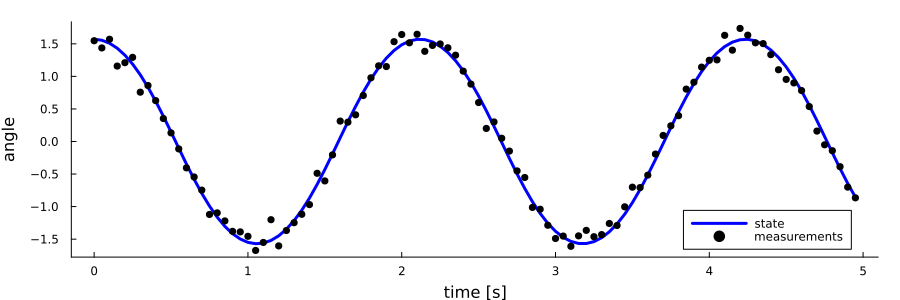

In [8]:
T = 100
Δt = 0.05
time = range(0.0, step=Δt, length=T)

states = zeros(2,T)
observations = zeros(T)

controls = zeros(T)

for k in 1:T
    
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    
    update!(pendulum, controls[k], Δt=Δt)
    
end

plot(xlabel="time [s]",ylabel="angle", size=(900,300))
plot!(time, states[1,:], color="blue", label="state")
scatter!(time, observations, color="black", label="measurements")

## ARX parameter estimation

In [9]:
# Length of trial
T      = 1000
time   = range(0.0, step=Δt, length=T);

In [10]:
# Number of harmonics
H = 1

# Basis expansion
# ϕ(x; N::Int64 = 10) = [1; cat([[cos.(2π*n*x); sin.(2π*n*x)] for n = 1:N]..., dims=1)]
ϕ(x; N::Int64 = 10) = [1; x]

ϕ (generic function with 1 method)

In [11]:
# Delay order
Lx = 10
Lu = 3

# Model order
M = (Lx+Lu)*H+1

14

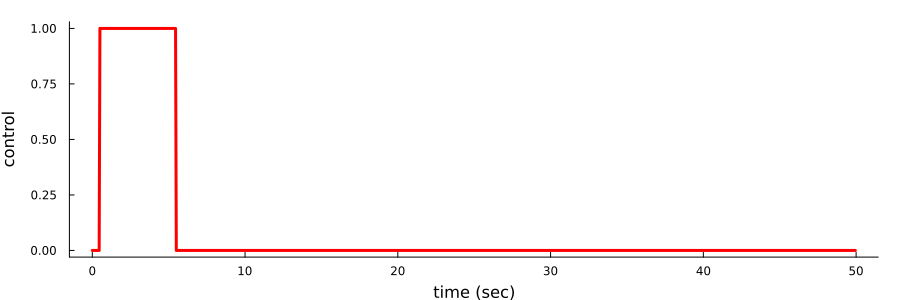

In [12]:
# Control policy
# Ω = 10 .^range(-6,stop=2, length=30)
# u_ = 100*mean([sin.(ω.*time) for ω in Ω]);

# function u(t)
#     u = 1.0
#     if t > 1.0
#         u = 0.0
#     end
#     return
# end
# u_ = u(range(0.0, step=nt*dt, length=T+thorizon))

u_ = [zeros(10); ones(100); zeros(T-110)];

plot(time, u_, size=(900,300), color="red", xlabel="time (sec)", ylabel="control")

In [13]:
@model function AR(θ0, τ0)
    
    ϕ = datavar(Vector{Float64})
    y = datavar(Float64)
    
    # Priors
    θ  ~ MvNormalMeanCovariance(mean(θ0), cov(θ0))
    τ  ~ GammaShapeRate(shape(τ0), rate(τ0))
    
    # Likelihood
    y ~ NormalMeanPrecision(dot(θ,ϕ), τ)
end

In [14]:
# Specify prior distributions
pτ0 = GammaShapeRate(1e1, 1e0)
pθ0 = MvNormalMeanCovariance(zeros(M), 10diagm(ones(M)))

MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)


In [15]:
# Initialize beliefs
pτ = [pτ0]
pθ = [pθ0]

1-element Vector{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}:
 MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)


In [16]:
# Clear memory
pτ = [pτ[end]]
pθ = [pθ[end]]

1-element Vector{MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}}:
 MvNormalMeanCovariance(
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0]
)


In [17]:
# VI options
num_iters = 10;
constraints = @constraints begin 
    q(θ, τ) = q(θ)q(τ)
end

# Initial state
init_state = [randn(), 0.0]

# Start system
pendulum = Pendulum(init_state, pendulum_mass, pendulum_length, mnoise_sd)

# Preallocate
z_ = zeros(2,T)
y_ = zeros(T)
xbuffer = zeros(Lx)
ubuffer = zeros(Lu)
μ_y = zeros(T)
σ_y = zeros(T)

@showprogress for (k,t) in enumerate(time)
    
    "Act upon environment"
    
    update!(pendulum, u_[k], Δt=Δt)
    
    "Update parameter beliefs"
    
    # Inputs
    xbuffer = backshift(xbuffer, pendulum.sensor)
    ubuffer = backshift(ubuffer, u_[k])
    ϕ_k = ϕ([xbuffer; ubuffer], N=H)
    
    # VI iterations
    results = inference(
        model         = AR(pθ[end], pτ[end]), 
        data          = (y = pendulum.sensor, ϕ = ϕ_k),
        constraints   = constraints, 
        iterations    = num_iters, 
        initmarginals = (θ = pθ[end], τ = pτ[end]),
        initmessages  = (θ = pθ[end], τ = pτ[end]),
        returnvars    = (θ = KeepLast(), τ = KeepLast(),),
    )
    
    # Update beliefs
    push!(pθ, results.posteriors[:θ])
    push!(pτ, results.posteriors[:τ])
    
    "Bookkeeping"
    
    # Prediction
    μ_y[k] = dot(mode(pθ[end]), ϕ_k)
    σ_y[k] = sqrt(ϕ_k'*cov(pθ[end])*ϕ_k + inv(mode(pτ[end])))
    
    # Track states and sensor measurements
    z_[:,k] = pendulum.state
    y_[k]   = pendulum.sensor
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


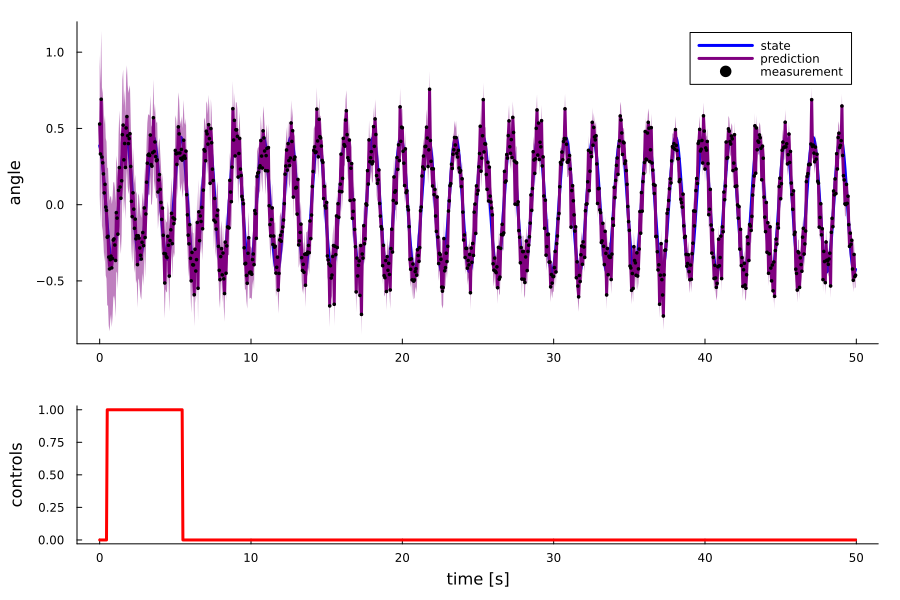

In [18]:
p1 = plot(time, z_[1,:], color="blue", label="state", ylabel="angle")
plot!(time, μ_y, ribbon=σ_y, color="purple", label="prediction")
scatter!( time, y_, color="black", markersize=2, label="measurement")
p4 = plot(time, u_, color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,600))

In [19]:
savefig("figures/NARX-EFE-pendulum_filtering.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/2dwalker/actinf-2dwalker/pendulum-test/figures/NARX-EFE-pendulum_filtering.png"

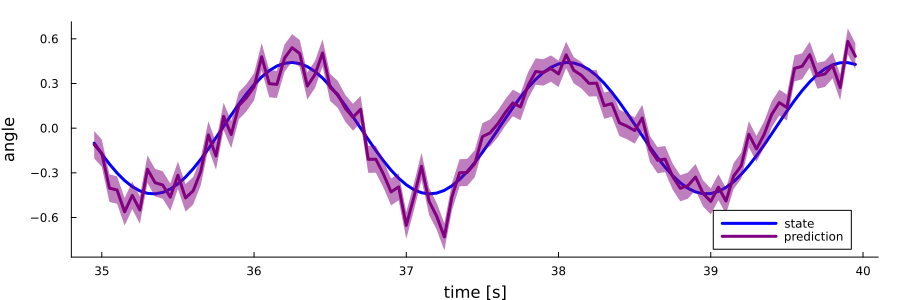

In [20]:
ix = 700:800
p2 = plot(size=(900,300), xlabel="time [s]", ylabel="angle")
plot!(time[ix], z_[1,ix], color="blue", label="state")
plot!(time[ix], μ_y[ix], color="purple", ribbon=σ_y[ix], label="prediction")

## Expected Free Energy minimization (controller)


In [21]:
function EFE(control, xbuffer, ubuffer, goalp, params; λ=0.01, time_horizon=1)
    "Expected Free Energy"
    
    # Unpack goal state
    μ_star, σ_star = goalp

    # Unpack parameters
    mθ, mτ = params

    # Recursive buffer
    vbuffer = 1e-8*ones(length(mθ))
    
    cEFE = 0
    for t in 1:time_horizon
        
        # Update control buffer
        ubuffer = backshift(ubuffer, control[t])
        
        # Prediction
        μ_y = dot(mθ, ϕ([xbuffer; ubuffer]))
        σ_y = sqrt(mθ'*diagm(vbuffer)*mθ + inv(mτ))

        # Calculate conditional entropy
        ambiguity = 0.5(log(2pi) + log(σ_y))
        
        # Risk as KL between marginal and goal prior
        risk = 0.5*(log(σ_star/σ_y) + (μ_y - μ_star)'*inv(σ_star)*(μ_y - μ_star) + tr(inv(σ_star)*σ_y))
        
        # Add to cumulative EFE
        cEFE += risk + ambiguity + λ*control[t]^2
        
        # Update previous 
        xbuffer = backshift(xbuffer, μ_y)
        vbuffer = backshift(vbuffer, σ_y^2)        
    end
    return cEFE
end;

In [22]:
function future(controls, xbuffer, ubuffer, params; time_horizon=1)
    
    μ_y = zeros(time_horizon)
    σ_y = zeros(time_horizon)

    # Unpack parameters
    mθ, mτ = params

    # Recursive buffer
    vbuffer = 1e-8*ones(length(mθ))
    
    for t in 1:time_horizon
        
        # Update control buffer
        ubuffer = backshift(ubuffer, controls[t])
        
        # Prediction
        μ_y[t] = dot(mθ, ϕ([xbuffer; ubuffer], N=H))
        σ_y[t] = sqrt(mθ'*diagm(vbuffer)*mθ + inv(mτ))
        
        # Update previous 
        xbuffer = backshift(xbuffer, μ_y[t])
        vbuffer = backshift(vbuffer, σ_y[t]^2)     
        
    end
    return μ_y, σ_y
end

future (generic function with 1 method)

In [23]:
# Length of trial
T      = 300
time   = range(0.0, step=Δt, length=T)
thorizon = 5;

# VI options
num_iters = 10;
constraints = @constraints begin 
    q(θ, τ) = q(θ)q(τ)
end

# Set control properties
setpoint = 0.0
goal_pdf = (setpoint, 1e-3)
u_lims = (-10, 10)

# Initial state
init_state = [randn(), 0.0]

# Start system
pendulum = Pendulum(init_state, pendulum_mass, pendulum_length, mnoise_sd)

# Preallocate
z_ = zeros(2,T)
y_ = zeros(T)
u_ = zeros(T+1)
ϕ_k = zeros(M)
xbuffer = zeros(Lx)
ubuffer = zeros(Lu)
pred_m = zeros(thorizon,T)
pred_s = zeros(thorizon,T)

@showprogress for (k,t) in enumerate(time)
    
    "Act upon environment"
    
    update!(pendulum, u_[k], Δt=Δt)
    
    "Update parameter beliefs"
    
    # Inputs
    xbuffer = backshift(xbuffer, pendulum.sensor)
    ubuffer = backshift(ubuffer, u_[k])
    ϕ_k = ϕ([xbuffer; ubuffer])
    
    # VI iterations
    results = inference(
        model         = AR(pθ[end], pτ[end]), 
        data          = (y = pendulum.sensor, ϕ = ϕ_k),
        constraints   = constraints, 
        iterations    = num_iters, 
        initmarginals = (θ = pθ[end], τ = pτ[end]),
        initmessages  = (θ = pθ[end], τ = pτ[end]),
        returnvars    = (θ = KeepLast(), τ = KeepLast(),),        
    )
    
    # Update beliefs
    push!(pθ, results.posteriors[:θ])
    push!(pτ, results.posteriors[:τ])
    
    "Optimal control"
    
    # Extract MAP parameters
    mθ = mode(results.posteriors[:θ])
    mτ = mode(results.posteriors[:τ])
    
    # Objective function
    J(policy) = EFE(policy, xbuffer, ubuffer, goal_pdf, (mθ, mτ), λ=1e-6, time_horizon=thorizon)

    # Minimize
    results = optimize(J, u_lims[1], u_lims[2], randn(thorizon), Fminbox(LBFGS()), autodiff=:forward)
    
    # Control law
    policy = Optim.minimizer(results)
    u_[k+1] = policy[1]
    
    "Bookkeeping"
    
    # Store future predictions
    pred_m[:,k], pred_s[:,k] = future(policy, 
                                      xbuffer, 
                                      ubuffer, 
                                      (mean(pθ[end]), mode(pτ[end])), 
                                      time_horizon=thorizon)

    # Track states and sensors
    z_[:,k] = pendulum.state
    y_[k]   = pendulum.sensor
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


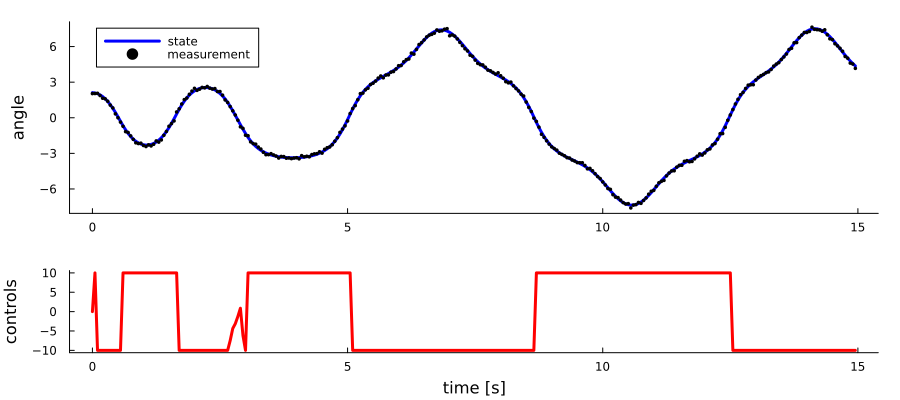

In [24]:
p1 = plot(time, z_[1,:], color="blue", label="state", ylabel="angle")
scatter!( time, y_, color="black", markersize=2, label="measurement")
p4 = plot(time, u_[1:end-1], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [25]:
savefig("figures/NARX-EFE-pendulum_trial00.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/2dwalker/actinf-2dwalker/pendulum-test/figures/NARX-EFE-pendulum_trial00.png"

[ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/2dwalker/actinf-2dwalker/pendulum-test/figures/NARX-EFE-pendulum_plan_trial00.gif


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/2dwalker/actinf-2dwalker/pendulum-test/figures/NARX-EFE-pendulum_plan_trial00.gif")
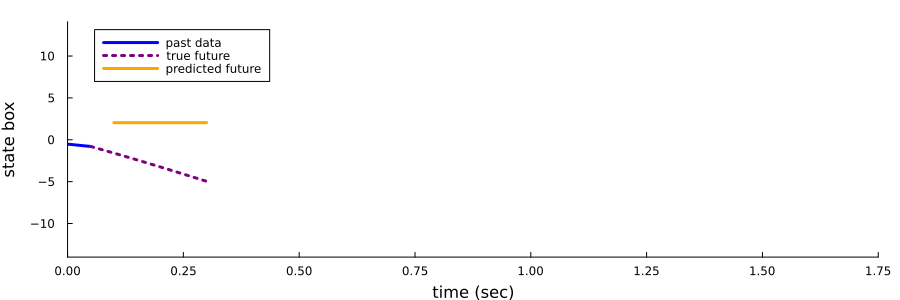

In [26]:
limsb = [minimum(z_[2,:])*1.5, maximum(z_[2,:])*1.5]

window = 20

anim = @animate for k in 2:(T-thorizon-1)
    
    if k <= window
        plot(time[1:k], z_[2,1:k], color="blue", xlims=(time[1], time[window+thorizon+1]+0.5), label="past data", ylabel="state box", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(time[k:k+thorizon], z_[2,k:k+thorizon], color="purple", label="true future", linestyle=:dot)
        plot!(time[k+1:k+thorizon], pred_m[:,k], ribbon=pred_s[:,k], label="predicted future", color="orange", legend=:topleft)
    else
        plot(time[k-window:k], z_[2,k-window:k], color="blue", xlims=(time[k-window], time[k+thorizon+1]+0.5), label="past data", ylabel="state box", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(time[k:k+thorizon], z_[2,k:k+thorizon], color="purple", label="true future", linestyle=:dot)
        plot!(time[k+1:k+thorizon], pred_m[:,k], ribbon=pred_s[:,k], label="prediction", color="orange", legend=:topleft)
    end
end
gif(anim, "figures/NARX-EFE-pendulum_plan_trial00.gif", fps=30)